# San Francisco Crime Classification

Andrew Lam, Svetlana Riva, John Kenney, Zhiwei (David) Tan <br />
W207 Section 1, Group 5 <br />
Final Project Notebook <br />
April 24, 2017

## Problem Description

In this notebook, we will be exploring the dataset from the San Francisco Crime Classification Kaggle: https://www.kaggle.com/c/sf-crime

As the name suggests, this dataset includes crime reports from San Francisco, spanning nearly 12 years (2003 - 2015).  The purpose of the Kaggle competition is to predict the category of the crime (e.g., larceny/theft, assault, drug/narcotic, etc.) that occurred, given time and location data.  

The training set and test set rotate every week, meaning the test set contains week 1,3,5,7… and the training set contains weeks 2,4,6,8…

Data fields include the following:
- Dates - timestamp of the crime incident
- Category - category of the crime incident, containing 39 unique groups; this is what our model(s) will attempt to predict in the test data
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week the crime was reported
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

## Import Libraries

In [40]:
import warnings
warnings.filterwarnings('ignore')

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import time

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

## Import Data
Import data and check the shape of train and test set.

In [3]:
import csv
from datetime import datetime
from time import time
ff = "./Data/train.csv" 
with open(ff, 'rt') as f:
    reader = csv.reader(f)
    train_data = list(reader)
ff = "./Data/test.csv" 
with open(ff, 'rt') as f:
    reader = csv.reader(f)
    test_data = list(reader)
    
#Convert to pandas data frame for better analysis
train_data_full = pd.DataFrame(train_data[1:], columns = train_data[0])
test_data = pd.DataFrame(test_data[1:], columns = test_data[0])
print ("Shape of train data", train_data_full.shape)
print ("Shape of test data", test_data.shape)

('Shape of train data', (878049, 9))
('Shape of test data', (884262, 7))


In [4]:
train_data_full.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.42436302145,37.8004143219856
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.42699532676599,37.80087263276921
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438737622757,37.771541172057795


In [5]:
test_data.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.39958770418998,37.7350510103906
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391522893042,37.7324323864471
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426001954961,37.7922124386284
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437393972517,37.7214120621391
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437393972517,37.7214120621391


## EDA

Run basic totals

In [6]:
category_count = train_data_full.groupby(['Category'])['Dates'].count()

print ("Training Data: Top 5 crimes")
print (category_count.sort_values(ascending=False)[:5])
print ("")

print ("Training Data: Lowest 5 crimes")
print (category_count.sort_values(ascending=True)[:5])
print ("")

print ("Training Data: All Category Counts")
print (category_count.sort_values(ascending=False))
print ("")

print ("Training Data: Cumulative Sum of Counts for Top 5 Crimes")
print (category_count.sort_values(ascending=False)[:5].cumsum())

# Top 5 crimes make up over 50% of the training data set.
# Focusing on predicting these as accurately as possible may give us a better accuracy score overall 

Training Data: Top 5 crimes
Category
LARCENY/THEFT     174900
OTHER OFFENSES    126182
NON-CRIMINAL       92304
ASSAULT            76876
DRUG/NARCOTIC      53971
Name: Dates, dtype: int64

Training Data: Lowest 5 crimes
Category
TREA                           6
PORNOGRAPHY/OBSCENE MAT       22
GAMBLING                     146
SEX OFFENSES NON FORCIBLE    148
EXTORTION                    256
Name: Dates, dtype: int64

Training Data: All Category Counts
Category
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SEC

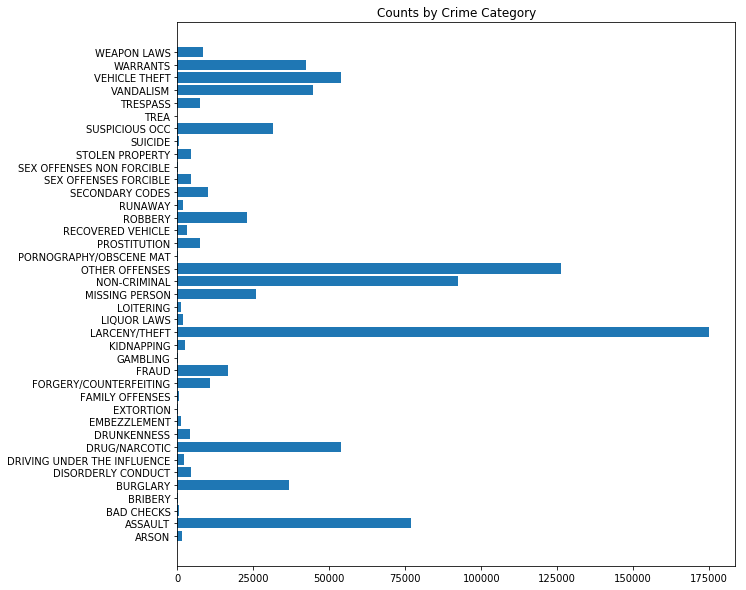

In [7]:
# Plotting a bar graph
plt.figure(figsize=(10,10))
plt.barh(np.arange(len(category_count.axes[0])), category_count)
plt.yticks(np.arange(len(category_count.axes[0])), category_count.axes[0])
plt.title("Counts by Crime Category")
plt.show()

## Feature Engineering

### Generate Neighborhood Feature

Converting X and Y coordinates into San Francisco neighborhoods using Zillows database via shapefiles

Shapefiles can be read via the pyshp package (https://pypi.python.org/pypi/pyshp)

https://www.zillow.com/howto/api/neighborhood-boundaries.htm

In [8]:
#read in the shapefile provided by zillow for california
sf = shapefile.Reader("./Data/ZillowNeighborhoods-CA.shp")
fields = sf.fields[1:] 
field_names = [field[0] for field in fields] 
nhood_list = []

#iterate through the shapefile records and retrieve the properties of each shapefile record 
#as well as its bbox coordinates 
#bbox: If the shape type contains multiple points this tuple describes the lower left (x,y) 
#coordinate and upper right corner coordinate creating a complete box around the points. 
#If the shapeType is a Null (shapeType == 0) then an AttributeError is raised.

#we will use the bbox to determine if our X and Y coordinates from the training data
#fall within the bbox of each neighborhood and then assign that neighborhood to the training data
for r in sf.shapeRecords():  
    atr = dict(zip(field_names, r.record))
    bbox = r.shape.bbox
    if atr['City'] == 'San Francisco':
        #print (dict(properties=atr,bbox=bbox))
        new_dict=dict(properties=atr,bbox=bbox)
        nhood_list.append(new_dict)
        
def coord_in_bbox(bbox, X, Y):
    if X>=bbox[0] and X<=bbox[2] and Y>=bbox[1] and Y<=bbox[3]:
        return True
    else:
        return False

def neighborhood(nhood_list, X, Y):
    for n in nhood_list:
        bbox = n['bbox']
        X = float(X)
        Y = float(Y)
        if coord_in_bbox(bbox, X, Y):
            return n['properties']['Name']

#Add neighborhood to train data
train_data_full['Neighborhood'] = train_data_full.apply(lambda x: neighborhood(nhood_list,x['X'],x['Y']),axis=1)

Neighborhood Counts

In [9]:
neighborhood_count = train_data_full.groupby(['Neighborhood'])['Dates'].count()

print ("Training Data: Top 5 Criminal Neighborhoods")
print (neighborhood_count.sort_values(ascending=False)[:5])
print ("")

print ("Training Data: Lowest 5 Criminal Neighborhoods")
print (neighborhood_count.sort_values(ascending=True)[:5])
print ("")

print ("Training Data: All Neighborhood Counts")
print (neighborhood_count.sort_values(ascending=False))
print ("")

print ("Training Data: Cumulative Sum of Counts for Top 5 Neighborhoods")
print (neighborhood_count.sort_values(ascending=False)[:5].cumsum())

#Top 5 neighborhoods make up almost 50% of the training data set.
#Also next steps is to bring in the category counts by neighborhood to see how these relate as well.

Training Data: Top 5 Criminal Neighborhoods
Neighborhood
South of Market    174414
Downtown            90894
Mission             83617
South Beach         36298
Bayview             32651
Name: Dates, dtype: int64

Training Data: Lowest 5 Criminal Neighborhoods
Neighborhood
Monterey Heights     14
Clarendon Heights    15
Buena Vista Park     72
Balboa Terrace       78
Treasure Island      93
Name: Dates, dtype: int64

Training Data: All Neighborhood Counts
Neighborhood
South of Market                             174414
Downtown                                     90894
Mission                                      83617
South Beach                                  36298
Bayview                                      32651
Bernal Heights                               28829
Hunters Point                                22562
Hayes Valley                                 22519
Western Addition                             21963
Excelsior                                    21074
Haight-Ashbury   

### Generate Date and Time Features
- Season  
- Month  
- Week  
- Day / Day of Week  
- Hour

In [10]:
#convert Dates to datetime
train_data_full['FinalDate'] = pd.to_datetime(train_data_full['Dates'], format='%Y-%m-%d %H:%M:%S')

In [11]:
#create functions to extract the needed datetime features
def season(date):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if date.timetuple().tm_yday in spring:
        return 2 #Spring
    elif date.timetuple().tm_yday in summer:
        return 3 #Summer
    elif date.timetuple().tm_yday in fall:
        return 4 #Fall
    else:
        return 1 #Winter
    
def getTimeCat(date):
    # extract time categories
    timecat = 4
    ts =  datetime.strptime(str(date),  '%Y-%m-%d %H:%M:%S').time()

    # --> Morning = 0400-1000
    mornStart = datetime.strptime('2016-12-31 04:01',  '%Y-%m-%d %H:%M').time()
    mornEnd = datetime.strptime('2016-12-31 10:00',  '%Y-%m-%d %H:%M').time()
    
    # --> Midday = 1000-1600
    midStart = datetime.strptime('2016-12-31 10:01',  '%Y-%m-%d %H:%M').time()
    midEnd = datetime.strptime('2016-12-31 16:00',  '%Y-%m-%d %H:%M').time()

    # --> Evening = 1600-2300
    eveStart = datetime.strptime('2016-12-31 16:01',  '%Y-%m-%d %H:%M').time()
    eveEnd = datetime.strptime('2016-12-31 23:00',  '%Y-%m-%d %H:%M').time()

    # --> Late Night = 2300-0400
    lateStart1 = datetime.strptime('2016-12-31 23:01',  '%Y-%m-%d %H:%M').time()
    lateEnd1 = datetime.strptime('2016-12-31 23:59',  '%Y-%m-%d %H:%M').time()
    lateStart2 = datetime.strptime('2016-12-31 00:01',  '%Y-%m-%d %H:%M').time()
    lateEnd2 = datetime.strptime('2016-12-31 04:01',  '%Y-%m-%d %H:%M').time()

    
    if ts >= mornStart and ts <= mornEnd:
      timecat = 0 #morning
    elif ts >= midStart and ts <= midEnd:
      timecat = 1 #midday
    elif ts >= eveStart and ts <= eveEnd:
      timecat = 2 #evening
    elif ts >= lateStart1 and ts <= lateEnd1:
      timecat = 3 #late night
    elif ts >= lateStart2 and ts <= lateEnd2:
      timecat = 3 #late night

    return timecat

In [12]:
#apply the functions
train_data_full['Season'] = train_data_full['FinalDate'].apply(lambda x: season(x))
train_data_full['DayOfMonth'] = train_data_full['FinalDate'].apply(lambda x: x.day)
train_data_full['Week'] = train_data_full['FinalDate'].apply(lambda x: x.week)
train_data_full['TimeCat'] = train_data_full['FinalDate'].apply(lambda x: getTimeCat(x))
train_data_full['Hour'] = train_data_full['FinalDate'].apply(lambda x: x.hour)

In [13]:
#get basic counts of each new feature
print("Season Counts")
print(train_data_full.groupby(['Season'])['Dates'].count())
print("")
print("Day of Month Counts")
print(train_data_full.groupby(['DayOfMonth'])['Dates'].count())
print("")
print("Week # Counts")
print(train_data_full.groupby(['Week'])['Dates'].count())
print("")
print("Time Category Counts")
print(train_data_full.groupby(['TimeCat'])['Dates'].count())
print("")
print("Hour Counts")
print(train_data_full.groupby(['Hour'])['Dates'].count())

Season Counts
Season
1    221171
2    227590
3    218856
4    210432
Name: Dates, dtype: int64

Day of Month Counts
DayOfMonth
1     32167
2     27471
3     28691
4     29905
5     29557
6     29482
7     29685
8     30339
9     29502
10    28395
11    27952
12    28223
13    28580
14    27670
15    28224
16    28146
17    29031
18    29793
19    30012
20    29963
21    30038
22    30589
23    29547
24    27987
25    26932
26    26870
27    27577
28    27269
29    27108
30    26589
31    14755
Name: Dates, dtype: int64

Week # Counts
Week
2     35857
4     35573
6     35564
8     35249
10    36474
12    35881
14    35797
16    35916
18    35545
20    34292
22    32560
24    31276
26    32698
28    32220
30    32674
32    32941
34    34014
36    33507
38    33974
40    34557
42    33911
44    34681
46    32813
48    30867
50    30431
52    28777
Name: Dates, dtype: int64

Time Category Counts
TimeCat
0    132011
1    266188
2    341211
3    138639
Name: Dates, dtype: int64

Hour Counts


Normalize and Standardize Date and X,Y

In [14]:
def normalize(series_field, df, new_field_name):
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    series_field = series_field.reshape((len(series_field), 1))
    scaler = scaler.fit(series_field)
    normalized = scaler.transform(series_field)
    df[new_field_name] = normalized
    return df

def standardize(series_field, df, new_field_name):
    scaler = preprocessing.StandardScaler()
    series_field = series_field.reshape((len(series_field), 1))
    scaler = scaler.fit(series_field)
    standardized = scaler.transform(series_field)
    df[new_field_name] = standardized
    return df

train_data_full = normalize(train_data_full['FinalDate'], train_data_full, 'DateNorm')
train_data_full = standardize(train_data_full['FinalDate'], train_data_full, 'DateStand')
train_data_full = normalize(train_data_full['X'], train_data_full, 'XNorm')
train_data_full = standardize(train_data_full['X'], train_data_full, 'XStand')
train_data_full = normalize(train_data_full['Y'], train_data_full, 'YNorm')
train_data_full = standardize(train_data_full['Y'], train_data_full, 'YStand')
train_data_full = standardize(train_data_full['DateNorm'], train_data_full, 'DateNS')
train_data_full = standardize(train_data_full['XNorm'], train_data_full, 'XNS')
train_data_full = standardize(train_data_full['YNorm'], train_data_full, 'YNS')

In [15]:
#get a list of features and their data types
train_data_full.dtypes

Dates                   object
Category                object
Descript                object
DayOfWeek               object
PdDistrict              object
Resolution              object
Address                 object
X                       object
Y                       object
Neighborhood            object
FinalDate       datetime64[ns]
Season                   int64
DayOfMonth               int64
Week                     int64
TimeCat                  int64
Hour                     int64
DateNorm               float64
DateStand              float64
XNorm                  float64
XStand                 float64
YNorm                  float64
YStand                 float64
DateNS                 float64
XNS                    float64
YNS                    float64
dtype: object

In [16]:
#convert to matrix for model processing
#Create sets of data where time and coords are standardized, scaled from [0,1], both
X_full = train_data_full.as_matrix()
Y = train_data_full["Category"].as_matrix()
X = train_data_full[["Dates","X","Y"]].as_matrix()
X_Norm = train_data_full[["DateNorm","XNorm","YNorm"]].as_matrix()
X_Std = train_data_full[["DateStand","XStand","YStand"]].as_matrix()
X_NS = train_data_full[["DateNS","XNS","YNS"]].as_matrix()
#Data set to investigate importance of time dimension
X_2d = train_data_full[["XStand","YStand"]].as_matrix()

In [14]:
#Encode categories into digits
le = preprocessing.LabelEncoder()
le.fit(Y)
n_classes = len(le.classes_)
Y_le = le.transform(Y)

#Shuffle the transformed data
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X_full.shape[0]))
X_Norm, X_Std, X_NS, X_2d, Y_le = X_Norm[shuffle],X_Std[shuffle],X_NS[shuffle],X_2d[shuffle],Y_le[shuffle]

trn_N, trn_S, trn_NS, trn_2d, tr_labels = X_Norm[:len(X_full)//2], \
                                            X_Std[:len(X_full)//2], \
                                            X_NS[:len(X_full)//2], \
                                            X_2d[:len(X_full)//2], \
                                            Y_le[:len(X_full)//2] 
                
tst_N, tst_S, tst_NS, tst_2d, tst_labels = X_Norm[len(X_full)//2:], \
                                            X_Std[len(X_full)//2:], \
                                            X_NS[len(X_full)//2:], \
                                            X_2d[len(X_full)//2:], \
                                            Y_le[len(X_full)//2:] 
trns = [trn_N, trn_S, trn_NS, trn_2d]
tsts = [tst_N, tst_S, tst_NS, tst_2d]

In [17]:
train_data_full.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Neighborhood,...,Hour,DateNorm,DateStand,XNorm,XStand,YNorm,YStand,DateNS,XNS,YNS
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747,Hayes Valley,...,23,1.000000,1.697407,0.043578,-0.107902,0.001276,0.007832,1.697407,-0.107902,0.007832
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747,Hayes Valley,...,23,1.000000,1.697407,0.043578,-0.107902,0.001276,0.007832,1.697407,-0.107902,0.007832
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.42436302145,37.8004143219856,Cow Hollow,...,23,0.999997,1.697397,0.044337,-0.057541,0.001770,0.064335,1.697397,-0.057541,0.064335
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.42699532676599,37.80087263276921,Cow Hollow,...,23,0.999996,1.697395,0.043030,-0.144262,0.001778,0.065338,1.697395,-0.144262,0.065338
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438737622757,37.771541172057795,Haight-Ashbury,...,23,0.999996,1.697395,0.037198,-0.531112,0.001217,0.001140,1.697395,-0.531112,0.001140


## Models

### GMM

In [ ]:
#Initialize the GMM parameters by setting GMM means using labeled data.
bics = []
accs = []
mod_names = ["Normalized","Standardized", "Normalized and Standardized", "2D Data Only"]
j=0

#Fit GMM for each data set and report performance
#Warning: Long Processing Time!
for tr in trns:
    j+=1
    #Initialize the GMM with the average coordinates for each crime category
    gm_means = np.array([tr[tr_labels == i].mean(axis=0) for i in range(n_classes)])
    gm_mod = GaussianMixture(n_components = n_classes, covariance_type='full', means_init=gm_means)
    gm_mod.fit(tr)
    pred = gm_mod.predict(tr)
    acc = np.mean(pred.ravel() == tr_labels.ravel()) * 100
    accs.append(acc)
    bic = gm_mod.bic(tr)
    bics.append(bic)
    print mod_names[j] + " Model:"
    print "Accuracy: %0.3f" %acc
    print "BIC: %0.3f\n" %bic

In [ ]:
#GMM With Normalization of 3 dimensions

norm = preprocessing.Normalizer()
#Apply after each dim has been standardized
X_NS2 = norm.fit_transform(X_Std)
print np.linalg.norm(X_NS2[1])

#Encode categories into digits
le = preprocessing.LabelEncoder()
le.fit(Y)
n_classes = len(le.classes_)
Y_le = le.transform(Y)

#Previous model was lopsided.
#Let's make a sample where each crime category is equally represented
samps = []
for i in range(n_classes):
    cat_i_only = X_NS2[Y_le == i]
    rands = np.random.randint(len(cat_i_only), size=1000)
    samps.append(cat_i_only[rands])
samps = np.array(samps)

samp_labs = []
for i in range(n_classes):
    samp_labs.append([i]*1000)
samp_labs = np.array(samp_labs).flatten()

#Fit the GMM and Assess Performance
bics = []
accs = []
samps_flat = samps.reshape(39000,3)
gm_means = np.array([samps[i].mean(axis=0) for i in range(len(samps))])
gm_mod = GaussianMixture(n_components = len(samps), covariance_type='full', means_init=gm_means)
gm_mod.fit(samps_flat)
pred = gm_mod.predict(samps_flat)
acc = np.mean(pred.ravel() == samp_labs.ravel()) * 100
accs.append(acc)
bic = gm_mod.bic(samps_flat)
bics.append(bic)
print "Accuracy: %0.3f" %acc
print "BIC: %0.3f\n" %bic

In [ ]:
#Warning: Long Processing Time
#Let's try using GMM to create an additional feature
#Find best GMM and use to create label column in X_full
cv_types = ['spherical', 'tied', 'diag', 'full']
comps = list(range(1,6))
Xs_trn = [trn_N, trn_S, trn_NS]
Xs_tst = [tst_N, tst_S, tst_NS]
bic = []
lowest_bic = np.infty
for comp in comps:
    for cv_type in cv_types:
        for i in range(len(Xs_trn)):
            gm_mod = GaussianMixture(n_components = comp, covariance_type=cv_type)
            gm_mod.fit(Xs_trn[i])
            bic.append(gm_mod.bic(Xs_trn[i]))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gm_mod
                print "Number of Comps: %d" %comp
                print "CV Type: %s" %cv_type
                print "i = %d" %i

In [ ]:
X.shape

In [ ]:
np.arange(X.shape[0])

In [ ]:
shuffle = np.random.permutation(np.arange(X.shape[0]))
shuffle

### Naive Bayes and Logistic Regression

#### Initial Models

In [18]:
# Another look at the data
train_data_full.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Neighborhood,...,Hour,DateNorm,DateStand,XNorm,XStand,YNorm,YStand,DateNS,XNS,YNS
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747,Hayes Valley,...,23,1.000000,1.697407,0.043578,-0.107902,0.001276,0.007832,1.697407,-0.107902,0.007832
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747,Hayes Valley,...,23,1.000000,1.697407,0.043578,-0.107902,0.001276,0.007832,1.697407,-0.107902,0.007832
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.42436302145,37.8004143219856,Cow Hollow,...,23,0.999997,1.697397,0.044337,-0.057541,0.001770,0.064335,1.697397,-0.057541,0.064335
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.42699532676599,37.80087263276921,Cow Hollow,...,23,0.999996,1.697395,0.043030,-0.144262,0.001778,0.065338,1.697395,-0.144262,0.065338
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438737622757,37.771541172057795,Haight-Ashbury,...,23,0.999996,1.697395,0.037198,-0.531112,0.001217,0.001140,1.697395,-0.531112,0.001140


In [19]:
# Column names of the data
train_data_full.dtypes

Dates                   object
Category                object
Descript                object
DayOfWeek               object
PdDistrict              object
Resolution              object
Address                 object
X                       object
Y                       object
Neighborhood            object
FinalDate       datetime64[ns]
Season                   int64
DayOfMonth               int64
Week                     int64
TimeCat                  int64
Hour                     int64
DateNorm               float64
DateStand              float64
XNorm                  float64
XStand                 float64
YNorm                  float64
YStand                 float64
DateNS                 float64
XNS                    float64
YNS                    float64
dtype: object

In [146]:
# Convert crime labels to numbers
leCrime = preprocessing.LabelEncoder()
crime = leCrime.fit_transform(train_data_full.Category)

In [147]:
# The "crime" variable is now a list of numbers ranging from 0 to 38
np.unique(crime)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [148]:
# Convert dates to date data type
train_data_full['Dates']  = pd.to_datetime(train_data_full['Dates'])

In [149]:
# Get binarized weekdays, districts, and hours
days = pd.get_dummies(train_data_full.DayOfWeek)
district = pd.get_dummies(train_data_full.PdDistrict)
hour = train_data_full.Dates.dt.hour
hour = pd.get_dummies(hour)

In [25]:
# Example of binarized hours
hour.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [150]:
# Build new array
trainData = pd.concat([hour, days, district], axis=1)
trainData['crime']=crime

In [27]:
trainData.head()

,0,1,2,3,4,5,6,7,8,9,...,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,crime
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,37
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,21
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,21
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,16
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,16


In [28]:
test_data['Dates'] = pd.to_datetime(test_data['Dates'])

In [29]:
# For test data, get dummies:
days = pd.get_dummies(test_data.DayOfWeek)
district = pd.get_dummies(test_data.PdDistrict)
hour = test_data.Dates.dt.hour
hour = pd.get_dummies(hour)

In [30]:
testData = pd.concat([hour, days, district], axis=1)

In [31]:
testData.head()

,0,1,2,3,4,5,6,7,8,9,...,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [151]:
# Create list of features for slicing
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_district = list(set(np.unique(train_data_full["PdDistrict"])))
feature_hour = [x for x in range(0,24)]
features = feature_day + feature_district + feature_hour

print features

['Monday', 'Tuesday', 'Friday', 'Wednesday', 'Thursday', 'Sunday', 'Saturday', 'CENTRAL', 'NORTHERN', 'INGLESIDE', 'PARK', 'MISSION', 'TENDERLOIN', 'RICHMOND', 'TARAVAL', 'BAYVIEW', 'SOUTHERN', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [152]:
# Split data into training and validation sets
training, validation = train_test_split(trainData, train_size=.60)

In [153]:
# Naive bayes
model = BernoulliNB(binarize=0.5)
model.fit(training[features], training['crime'])
predicted = np.array(model.predict_proba(validation[features]))
log_loss(validation['crime'], predicted) 

# model_predicted = model.predict(validation[features])
# model.score(validation[features], validation['crime'])

# print ('Accuracy of Bernoulli Naive Bayes: {0:.3f}'.format(model.score(validation[features], validation['crime'])))

2.5837821956511036

In [41]:
# Logistic regression
model = LogisticRegression(C=.01)
model.fit(training[features], training['crime'])
predicted = np.array(model.predict_proba(validation[features]))
log_loss(validation['crime'], predicted) 

# model_predicted = model.predict(validation[features])
# model.score(validation[features], validation['crime'])

# print ('Accuracy of Logistics Regression: {0:.3f}'.format(model.score(validation[features], validation['crime'])))

2.5924672532906263

#### Using Neighborhood Feature

In [161]:
# Get binarized weekdays, neighborhoods, and hours
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
hour = train_data_full.Dates.dt.hour
hour = pd.get_dummies(hour)

In [162]:
# Build new array
trainData2 = pd.concat([hour, days, neighborhoods], axis=1)
trainData2['crime']=crime

In [163]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(np.unique(train_data_full["Neighborhood"])))
feature_hour = [x for x in range(0,24)]
features = feature_day + feature_neighborhood + feature_hour
features.remove(None)

print features

['Monday', 'Tuesday', 'Friday', 'Wednesday', 'Thursday', 'Sunday', 'Saturday', 'Clarendon Heights', 'Hayes Valley', 'Inner Richmond', 'Financial District', 'Lake', 'Sunnyside', 'Midtown Terrace', 'Glen Park', 'Sherwood Forest', 'Forest Knolls', 'West Portal', 'Golden Gate Heights', 'Inner Sunset', 'Yerba Buena Island', 'Cow Hollow', 'Parkside', 'Sea Cliff', 'North Panhandle', 'Bernal Heights', 'Central Waterfront - Dogpatch', 'Buena Vista Park', 'Lakeshore', 'Lower Pacific Heights', 'St. Francis Wood', 'Portola', 'Potrero Hill', 'Balboa Terrace', 'Pacific Heights', 'Duboce Triangle', 'Eureka Valley - Dolores Heights - Castro', 'Central Sunset', 'Excelsior', 'Downtown', 'Merced Heights', 'Visitacion Valley', 'Miraloma Park', 'Monterey Heights', 'Telegraph Hill', 'Mission Bay', 'Marina', 'Ingleside Heights', 'Anza Vista', 'Mount Davidson Manor', 'Golden Gate Park', 'Forest Hill', 'Haight-Ashbury', 'Nob Hill', 'South of Market', 'Yerba Buena', 'Ingleside', 'Diamond Heights', 'Chinatown', 

In [164]:
training2, validation2 = train_test_split(trainData2, train_size=.60)

In [166]:
# Naive bayes
model = BernoulliNB(binarize=0.5)
model.fit(training2[features], training2['crime'])
predicted = np.array(model.predict_proba(validation2[features]))
log_loss(validation2['crime'], predicted) 

model_predicted = model.predict(validation2[features])
# model.score(validation[features], validation['crime'])

# print ('Accuracy of Bernoulli Naive Bayes: {0:.3f}'.format(model.score(validation[features], validation['crime'])))

#### Parameter Settings

In [137]:
def smoothing(alphas):

### STUDENT START ###
    clf = BernoulliNB()
    g = GridSearchCV(clf, param_grid = alphas)
    g.fit(training2[features], training2['crime'])
    for score in g.grid_scores_:
        print score
    
    # Accuracy when alpha=0
    clf.alpha = 0.0
    clf.fit(training2[features], training2['crime'])
    print ""
    print "Accuracy when alpha=0:", clf.score(validation2[features], validation2['crime'])
        
    return g

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 15.0, 20.0]}
nb = smoothing(alphas)

mean: 0.00168, std: 0.00000, params: {'alpha': 0.0}
mean: 0.22373, std: 0.00094, params: {'alpha': 0.0001}
mean: 0.22373, std: 0.00094, params: {'alpha': 0.001}
mean: 0.22374, std: 0.00093, params: {'alpha': 0.01}
mean: 0.22373, std: 0.00094, params: {'alpha': 0.1}
mean: 0.22372, std: 0.00096, params: {'alpha': 0.5}
mean: 0.22378, std: 0.00106, params: {'alpha': 1.0}
mean: 0.22386, std: 0.00109, params: {'alpha': 2.0}
mean: 0.22403, std: 0.00115, params: {'alpha': 10.0}
mean: 0.22392, std: 0.00110, params: {'alpha': 15.0}
mean: 0.22384, std: 0.00100, params: {'alpha': 20.0}

Accuracy when alpha=0: 0.00178235863561


In [138]:
print nb.best_params_

{'alpha': 10.0}


#### Confusion Matrix

In [167]:
# Determine if this is the order of categories for the confusion matrix -- yes, it is
categories = np.unique(train_data_full.Category)
print categories

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 'FRAUD' 'GAMBLING'
 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING' 'MISSING PERSON'
 'NON-CRIMINAL' 'OTHER OFFENSES' 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION'
 'RECOVERED VEHICLE' 'ROBBERY' 'RUNAWAY' 'SECONDARY CODES'
 'SEX OFFENSES FORCIBLE' 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY'
 'SUICIDE' 'SUSPICIOUS OCC' 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT'
 'WARRANTS' 'WEAPON LAWS']


In [169]:
categories_encoded = leCrime.transform(categories) 
categories_encoded

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [225]:
# Confusion matrix 
# True labels are the rows; predicted labels are the columns 
np.set_printoptions(threshold=np.inf)
cm = confusion_matrix(validation2['crime'], model_predicted, labels = categories_encoded)
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,50,0,0,8,0,0,6,0,0,...,0,0,0,0,0,0,2,21,0,0
1,0,1712,0,0,29,0,0,1137,0,0,...,0,0,0,1,0,0,39,751,0,0
2,0,1,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,7,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,2,0,0
4,0,303,0,0,120,0,0,254,0,0,...,0,0,0,1,0,0,18,192,0,0
5,0,58,0,0,3,0,0,44,0,0,...,0,0,0,0,0,0,0,24,0,0
6,0,75,0,0,6,0,0,16,0,0,...,0,0,0,0,0,0,7,27,0,0
7,0,333,0,0,20,0,0,2544,0,0,...,0,0,0,0,0,0,3,174,0,0
8,0,102,0,0,3,0,0,62,0,0,...,0,0,0,0,0,0,2,34,0,0
9,0,4,0,0,1,0,0,11,0,0,...,0,0,0,0,0,0,1,5,0,0


In [226]:
# Sum across columns
cm.sum(axis=1)

array([  603, 30773,   159,   111, 14535,  1748,   911, 21528,  1735,
         483,    84,   194,  4218,  6691,    58,   942, 69930,   778,
         497, 10369, 37100, 50536,    12,  2960,  1224,  9162,   796,
        3877,  1755,    59,  1848,   216, 12657,     2,  2957, 17777,
       21439, 17081,  3415])

In [246]:
# Normalized confusion matrix 
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
pd.DataFrame(cm_normalized)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,0.082919,0.0,0.0,0.013267,0.0,0.0,0.009950,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.003317,0.034826,0.0,0.0
1,0.0,0.055633,0.0,0.0,0.000942,0.0,0.0,0.036948,0.0,0.000000,...,0.0,0.0,0.0,0.000032,0.0,0.0,0.001267,0.024405,0.0,0.0
2,0.0,0.006289,0.0,0.0,0.000000,0.0,0.0,0.031447,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.006289,0.0,0.0
3,0.0,0.063063,0.0,0.0,0.000000,0.0,0.0,0.018018,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.018018,0.0,0.0
4,0.0,0.020846,0.0,0.0,0.008256,0.0,0.0,0.017475,0.0,0.000000,...,0.0,0.0,0.0,0.000069,0.0,0.0,0.001238,0.013209,0.0,0.0
5,0.0,0.033181,0.0,0.0,0.001716,0.0,0.0,0.025172,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.013730,0.0,0.0
6,0.0,0.082327,0.0,0.0,0.006586,0.0,0.0,0.017563,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.007684,0.029638,0.0,0.0
7,0.0,0.015468,0.0,0.0,0.000929,0.0,0.0,0.118172,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000139,0.008082,0.0,0.0
8,0.0,0.058790,0.0,0.0,0.001729,0.0,0.0,0.035735,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.001153,0.019597,0.0,0.0
9,0.0,0.008282,0.0,0.0,0.002070,0.0,0.0,0.022774,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.002070,0.010352,0.0,0.0


In [254]:
# Find categories we're doing well on
diagonal = np.diag(cm_normalized)

for item in enumerate(diagonal):
    print item

(0, 0.0)
(1, 0.055633184934845481)
(2, 0.0)
(3, 0.0)
(4, 0.0082559339525283791)
(5, 0.0)
(6, 0.0)
(7, 0.11817168338907469)
(8, 0.0)
(9, 0.0)
(10, 0.0)
(11, 0.0)
(12, 0.0)
(13, 0.0)
(14, 0.0)
(15, 0.0)
(16, 0.74217074217074219)
(17, 0.0)
(18, 0.0)
(19, 0.043495033272253833)
(20, 0.047412398921832882)
(21, 0.36900427418078202)
(22, 0.0)
(23, 0.076013513513513514)
(24, 0.0)
(25, 0.0)
(26, 0.0)
(27, 0.0)
(28, 0.0)
(29, 0.0)
(30, 0.0)
(31, 0.0)
(32, 0.0)
(33, 0.0)
(34, 0.0)
(35, 0.0019688361365809755)
(36, 0.061056952283222166)
(37, 0.0)
(38, 0.0)


In [256]:
# It appears that we're doing well on index 16, which is larceny/theft
print categories[16]

LARCENY/THEFT


In [227]:
# Function to plot the confusion matrix
# This code was adapted from the following website: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

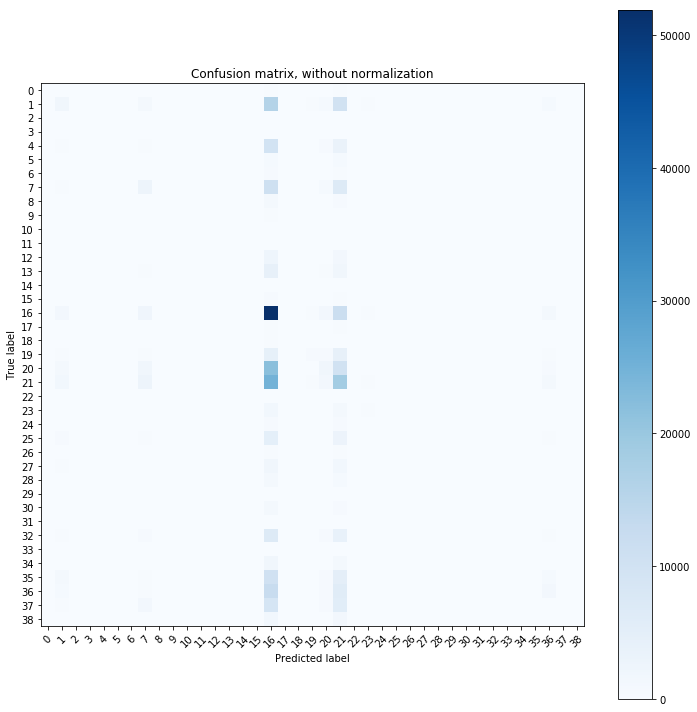

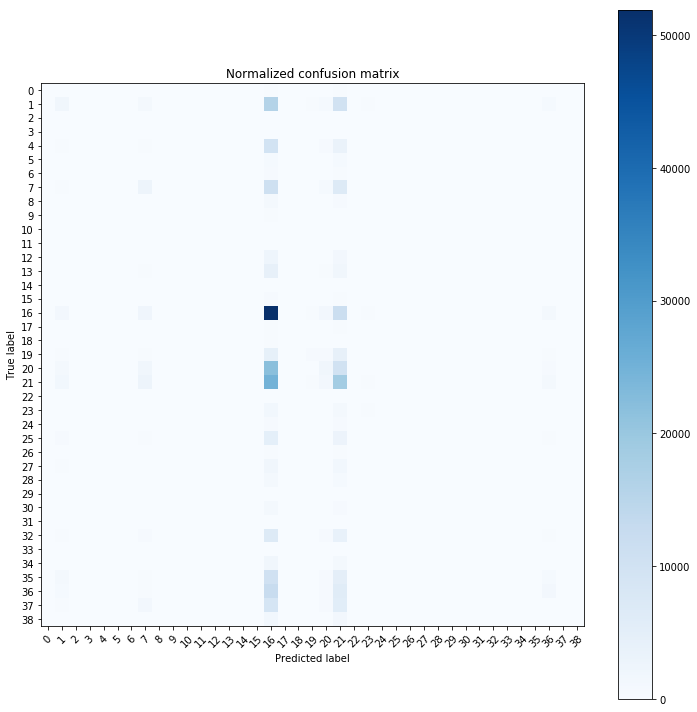

In [228]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=categories_encoded, 
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=categories_encoded, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Based on the off-diagonals, the plot for the normalized confusion matrix seems to suggest that (20,16) and (21,16) are doing poorly.

In [260]:
print 16, categories[16]
print 20, categories[20]
print 21, categories[21]

16 LARCENY/THEFT
20 NON-CRIMINAL
21 OTHER OFFENSES


This suggests that "Non-Criminal" and "Other Offenses" are being incorrectly labeled as "Larcency/Theft".

In [261]:
# As mentioned before, here are the top 5 crimes:
print ("Training Data: Top 5 crimes")
print (category_count.sort_values(ascending=False)[:5])
print ("")

Training Data: Top 5 crimes
Category
LARCENY/THEFT     174900
OTHER OFFENSES    126182
NON-CRIMINAL       92304
ASSAULT            76876
DRUG/NARCOTIC      53971
Name: Dates, dtype: int64



In [265]:
# Printing the index for each crime
for item in enumerate(categories):
    print item

(0, 'ARSON')
(1, 'ASSAULT')
(2, 'BAD CHECKS')
(3, 'BRIBERY')
(4, 'BURGLARY')
(5, 'DISORDERLY CONDUCT')
(6, 'DRIVING UNDER THE INFLUENCE')
(7, 'DRUG/NARCOTIC')
(8, 'DRUNKENNESS')
(9, 'EMBEZZLEMENT')
(10, 'EXTORTION')
(11, 'FAMILY OFFENSES')
(12, 'FORGERY/COUNTERFEITING')
(13, 'FRAUD')
(14, 'GAMBLING')
(15, 'KIDNAPPING')
(16, 'LARCENY/THEFT')
(17, 'LIQUOR LAWS')
(18, 'LOITERING')
(19, 'MISSING PERSON')
(20, 'NON-CRIMINAL')
(21, 'OTHER OFFENSES')
(22, 'PORNOGRAPHY/OBSCENE MAT')
(23, 'PROSTITUTION')
(24, 'RECOVERED VEHICLE')
(25, 'ROBBERY')
(26, 'RUNAWAY')
(27, 'SECONDARY CODES')
(28, 'SEX OFFENSES FORCIBLE')
(29, 'SEX OFFENSES NON FORCIBLE')
(30, 'STOLEN PROPERTY')
(31, 'SUICIDE')
(32, 'SUSPICIOUS OCC')
(33, 'TREA')
(34, 'TRESPASS')
(35, 'VANDALISM')
(36, 'VEHICLE THEFT')
(37, 'WARRANTS')
(38, 'WEAPON LAWS')


Based off of the above, we can see that the indexes for the top 5 crime are as follows:
- (16, 'LARCENY/THEFT')
- (21, 'OTHER OFFENSES')
- (20, 'NON-CRIMINAL')
- (1, 'ASSAULT')
- (7, 'DRUG/NARCOTIC')

In [290]:
# For the top 5 crimes, find the biggest category it is being confused with
for crime in [16, 21, 20, 1, 7]:
    max = 0
    for item in enumerate(cm_normalized[crime]):
        if (item[0] != crime) & (item[1] > max):
            max = item[1]
            max_index = item[0]
        else:
            continue
    print categories[crime], "is being confused as", categories[max_index]

LARCENY/THEFT is being confused as OTHER OFFENSES
OTHER OFFENSES is being confused as LARCENY/THEFT
NON-CRIMINAL is being confused as LARCENY/THEFT
ASSAULT is being confused as LARCENY/THEFT
DRUG/NARCOTIC is being confused as LARCENY/THEFT


#### Adding in Other Time and Location Features

In [154]:
# Get binarized weekdays, neighborhoods, and hours
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
season = pd.get_dummies(train_data_full.Season)
dayofmonth = pd.get_dummies(train_data_full.DayOfMonth)
week = pd.get_dummies(train_data_full.Week)
timecat = pd.get_dummies(train_data_full.TimeCat)
hour = train_data_full.Dates.dt.hour
hour = pd.get_dummies(hour)

In [155]:
# Build new array
trainData3 = pd.concat([days, neighborhoods, season, dayofmonth, week, timecat, hour], axis=1)
trainData3['crime']=crime

In [156]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(np.unique(train_data_full["Neighborhood"])))
# feature_season = list(set(np.unique(train_data_full["Season"])))
feature_dayofmonth = list(set(np.unique(train_data_full["DayOfMonth"])))
# feature_week = list(set(np.unique(train_data_full["Week"])))
feature_timecat = list(set(np.unique(train_data_full["TimeCat"])))
# feature_hour = [x for x in range(0,24)]
# features = feature_day + feature_neighborhood + feature_season + feature_dayofmonth + feature_week + feature_timecat + feature_hour
features = feature_day + feature_neighborhood + feature_dayofmonth + feature_timecat 
features.remove(None)

print features

['Monday', 'Tuesday', 'Friday', 'Wednesday', 'Thursday', 'Sunday', 'Saturday', 'Clarendon Heights', 'Hayes Valley', 'Inner Richmond', 'Financial District', 'Lake', 'Sunnyside', 'Midtown Terrace', 'Glen Park', 'Sherwood Forest', 'Forest Knolls', 'West Portal', 'Golden Gate Heights', 'Inner Sunset', 'Yerba Buena Island', 'Cow Hollow', 'Parkside', 'Sea Cliff', 'North Panhandle', 'Bernal Heights', 'Central Waterfront - Dogpatch', 'Buena Vista Park', 'Lakeshore', 'Lower Pacific Heights', 'St. Francis Wood', 'Portola', 'Potrero Hill', 'Balboa Terrace', 'Pacific Heights', 'Duboce Triangle', 'Eureka Valley - Dolores Heights - Castro', 'Central Sunset', 'Excelsior', 'Downtown', 'Merced Heights', 'Visitacion Valley', 'Miraloma Park', 'Monterey Heights', 'Telegraph Hill', 'Mission Bay', 'Marina', 'Ingleside Heights', 'Anza Vista', 'Mount Davidson Manor', 'Golden Gate Park', 'Forest Hill', 'Haight-Ashbury', 'Nob Hill', 'South of Market', 'Yerba Buena', 'Ingleside', 'Diamond Heights', 'Chinatown', 

In [157]:
training3, validation3 = train_test_split(trainData3, train_size=.60)

In [160]:
# Naive bayes
model = BernoulliNB(binarize=0.5)
model.fit(training3[features], training3['crime'])
predicted = np.array(model.predict_proba(validation3[features]))
print "log loss", log_loss(validation3['crime'], predicted) 

# model_predicted = model.predict(validation3[features])
# s = model.score(validation3[features], validation3['crime'])
# print ('Accuracy of Bernoulli Naive Bayes: {0:.3f}'.format(s))

log loss 2.75301534787


#### Adding Year and Month

In [83]:
# Get binarized weekdays, neighborhoods, and hours
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
hour = train_data_full.Dates.dt.hour
hour = pd.get_dummies(hour)

In [84]:
# Create year and month features
year = train_data_full.Dates.dt.year
year = pd.get_dummies(year)

month = train_data_full.Dates.dt.month
month = pd.get_dummies(month)

In [85]:
# Build new array
trainData4 = pd.concat([days, neighborhoods, hour, month], axis=1)
trainData4['crime']=crime

In [86]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(np.unique(train_data_full["Neighborhood"])))
feature_hour = [x for x in range(0,24)]
feature_year = list(year.columns)
feature_month = list(month.columns)
features = feature_day + feature_neighborhood + feature_hour + feature_month
features.remove(None)

print features

['Monday', 'Tuesday', 'Friday', 'Wednesday', 'Thursday', 'Sunday', 'Saturday', 'Clarendon Heights', 'Hayes Valley', 'Inner Richmond', 'Financial District', 'Lake', 'Sunnyside', 'Midtown Terrace', 'Glen Park', 'Sherwood Forest', 'Forest Knolls', 'West Portal', 'Golden Gate Heights', 'Inner Sunset', 'Yerba Buena Island', 'Cow Hollow', 'Parkside', 'Sea Cliff', 'North Panhandle', 'Bernal Heights', 'Central Waterfront - Dogpatch', 'Buena Vista Park', 'Lakeshore', 'Lower Pacific Heights', 'St. Francis Wood', 'Portola', 'Potrero Hill', 'Balboa Terrace', 'Pacific Heights', 'Duboce Triangle', 'Eureka Valley - Dolores Heights - Castro', 'Central Sunset', 'Excelsior', 'Downtown', 'Merced Heights', 'Visitacion Valley', 'Miraloma Park', 'Monterey Heights', 'Telegraph Hill', 'Mission Bay', 'Marina', 'Ingleside Heights', 'Anza Vista', 'Mount Davidson Manor', 'Golden Gate Park', 'Forest Hill', 'Haight-Ashbury', 'Nob Hill', 'South of Market', 'Yerba Buena', 'Ingleside', 'Diamond Heights', 'Chinatown', 

In [87]:
training4, validation4 = train_test_split(trainData4, train_size=.60)

In [88]:
# Naive bayes
model = BernoulliNB(binarize=0.5)
model.fit(training4[features], training4['crime'])
predicted = np.array(model.predict_proba(validation4[features]))
log_loss(validation4['crime'], predicted) 

# model_predicted = model.predict(validation[features])
# model.score(validation[features], validation['crime'])

# print ('Accuracy of Bernoulli Naive Bayes: {0:.3f}'.format(model.score(validation[features], validation['crime'])))

2.5867490965881745

#### Logistic Regression with XY Coordinates

In [69]:
print min(train_data_full['X'])
print max(train_data_full['X'])

-120.5
-122.51364206429


In [70]:
print min(train_data_full['Y'])
print max(train_data_full['Y'])

37.7078790224135
90.0


In [71]:
trainData5 = train_data_full[['X', 'Y']]
trainData5['crime']=crime

In [72]:
trainData5.head()

,X,Y,crime
0,-122.425891675136,37.7745985956747,37
1,-122.425891675136,37.7745985956747,21
2,-122.42436302145,37.8004143219856,21
3,-122.42699532676599,37.80087263276921,16
4,-122.438737622757,37.771541172057795,16


In [73]:
training5, validation5 = train_test_split(trainData5, train_size=.60)

In [74]:
# Logistic regression
model = LogisticRegression(C=.01)
model.fit(trainData5[['X','Y']], trainData5['crime'])
predicted = np.array(model.predict_proba(validation5[['X','Y']]))
log_loss(validation5['crime'], predicted) 

# model_predicted = model.predict(validation[features])
# model.score(validation[features], validation['crime'])

# print ('Accuracy of Logistics Regression: {0:.3f}'.format(model.score(validation[features], validation['crime'])))

2.6793829180943369

#### Day of Week, Neighborhood, Hour, Season

In [90]:
# Get binarized weekdays, neighborhoods, hours, seasons
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
hour = train_data_full.Dates.dt.hour
hour = pd.get_dummies(hour)
season = pd.get_dummies(train_data_full.Season)

In [91]:
# Build new array
trainData6 = pd.concat([days, neighborhoods, hour, season], axis=1)
trainData6['crime']=crime

In [92]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(np.unique(train_data_full["Neighborhood"])))
feature_hour = [x for x in range(0,24)]
feature_season = list(set(np.unique(train_data_full["Season"])))
features = feature_day + feature_neighborhood + feature_hour + feature_season
features.remove(None)

print features

['Monday', 'Tuesday', 'Friday', 'Wednesday', 'Thursday', 'Sunday', 'Saturday', 'Clarendon Heights', 'Hayes Valley', 'Inner Richmond', 'Financial District', 'Lake', 'Sunnyside', 'Midtown Terrace', 'Glen Park', 'Sherwood Forest', 'Forest Knolls', 'West Portal', 'Golden Gate Heights', 'Inner Sunset', 'Yerba Buena Island', 'Cow Hollow', 'Parkside', 'Sea Cliff', 'North Panhandle', 'Bernal Heights', 'Central Waterfront - Dogpatch', 'Buena Vista Park', 'Lakeshore', 'Lower Pacific Heights', 'St. Francis Wood', 'Portola', 'Potrero Hill', 'Balboa Terrace', 'Pacific Heights', 'Duboce Triangle', 'Eureka Valley - Dolores Heights - Castro', 'Central Sunset', 'Excelsior', 'Downtown', 'Merced Heights', 'Visitacion Valley', 'Miraloma Park', 'Monterey Heights', 'Telegraph Hill', 'Mission Bay', 'Marina', 'Ingleside Heights', 'Anza Vista', 'Mount Davidson Manor', 'Golden Gate Park', 'Forest Hill', 'Haight-Ashbury', 'Nob Hill', 'South of Market', 'Yerba Buena', 'Ingleside', 'Diamond Heights', 'Chinatown', 

In [93]:
training6, validation6 = train_test_split(trainData6, train_size=.60)

In [94]:
# Naive bayes
model = BernoulliNB(binarize=0.5)
model.fit(training6[features], training6['crime'])
predicted = np.array(model.predict_proba(validation6[features]))
log_loss(validation6['crime'], predicted) 

# model_predicted = model.predict(validation[features])
# model.score(validation[features], validation['crime'])

# print ('Accuracy of Bernoulli Naive Bayes: {0:.3f}'.format(model.score(validation[features], validation['crime'])))

2.5685030078931734

#### Day of Week, Neighborhood, Hour, XNorm, YNorm

In [114]:
# Get binarized weekdays, neighborhoods, hours
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
hour = train_data_full.Dates.dt.hour
hour = pd.get_dummies(hour)

In [109]:
print min(train_data_full['XNorm'])
print max(train_data_full['XNorm'])

0.0
1.0


In [107]:
print min(train_data_full['YNorm'])
print max(train_data_full['YNorm'])

0.0
1.0


In [115]:
xnorm = train_data_full['XNorm']
ynorm = train_data_full['YNorm']

In [116]:
# Build new array
trainData7 = pd.concat([days, neighborhoods, hour, xnorm, ynorm], axis=1)
trainData7['crime']=crime

In [119]:
trainData7.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Anza Vista,Balboa Terrace,Bayview,...,17,18,19,20,21,22,23,XNorm,YNorm,crime
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0.043578,0.001276,37
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0.043578,0.001276,21
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0.044337,0.001770,21
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0.043030,0.001778,16
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0.037198,0.001217,16


In [127]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(np.unique(train_data_full["Neighborhood"])))
feature_hour = [x for x in range(0,24)]
features = feature_day + feature_neighborhood + feature_hour 
features.append("XNorm")
features.append("YNorm")
features.remove(None)

print features

['Monday', 'Tuesday', 'Friday', 'Wednesday', 'Thursday', 'Sunday', 'Saturday', 'Clarendon Heights', 'Hayes Valley', 'Inner Richmond', 'Financial District', 'Lake', 'Sunnyside', 'Midtown Terrace', 'Glen Park', 'Sherwood Forest', 'Forest Knolls', 'West Portal', 'Golden Gate Heights', 'Inner Sunset', 'Yerba Buena Island', 'Cow Hollow', 'Parkside', 'Sea Cliff', 'North Panhandle', 'Bernal Heights', 'Central Waterfront - Dogpatch', 'Buena Vista Park', 'Lakeshore', 'Lower Pacific Heights', 'St. Francis Wood', 'Portola', 'Potrero Hill', 'Balboa Terrace', 'Pacific Heights', 'Duboce Triangle', 'Eureka Valley - Dolores Heights - Castro', 'Central Sunset', 'Excelsior', 'Downtown', 'Merced Heights', 'Visitacion Valley', 'Miraloma Park', 'Monterey Heights', 'Telegraph Hill', 'Mission Bay', 'Marina', 'Ingleside Heights', 'Anza Vista', 'Mount Davidson Manor', 'Golden Gate Park', 'Forest Hill', 'Haight-Ashbury', 'Nob Hill', 'South of Market', 'Yerba Buena', 'Ingleside', 'Diamond Heights', 'Chinatown', 

In [128]:
training7, validation7 = train_test_split(trainData7, train_size=.60)

In [129]:
# Naive bayes
model = BernoulliNB(binarize=0.5)
model.fit(training7[features], training7['crime'])
predicted = np.array(model.predict_proba(validation7[features]))
log_loss(validation7['crime'], predicted) 

# model_predicted = model.predict(validation[features])
# model.score(validation[features], validation['crime'])

# print ('Accuracy of Bernoulli Naive Bayes: {0:.3f}'.format(model.score(validation[features], validation['crime'])))

2.560001449787944

In [131]:
# Logistic regression
model = LogisticRegression(C=.01)
model.fit(training7[features], training7['crime'])
predicted = np.array(model.predict_proba(validation7[features]))
log_loss(validation['crime'], predicted) 

# model_predicted = model.predict(validation[features])
# model.score(validation[features], validation['crime'])

# print ('Accuracy of Logistics Regression: {0:.3f}'.format(model.score(validation[features], validation['crime'])))

2.7777037367510506

## Overall Results

In [95]:
# Columns: model / feature set, validation set log loss, and possibly test set log loss